# Hands-on Lab 9: SVD/PCA Classification for Voice Commands

### EECS 16B: Designing Information Devices and Systems II, Spring 2022

Written by Nathaniel Mailoa and Emily Naviasky (2016). 

Updated by Julian Chan (2018), Peter Schafhalter (2019). Vin Ramamurti and Zain Zaidi (Fall 2019)

Updated by Kaitlyn Chan, Steven Lu (2021)

Updated by Steven Lu, Megan Zeng, Ke Wang (2022)

## Table of Contents

* [Introduction / Lab Note](#intro)
* [Part 0: Preparing your Launchpad](#part0)
* [Part 1: Setting up your Circuit](#part1)
* [Part 2: Data Collection](#part2)
* [Part 3: Data Preprocessing](#part3)
* [Part 4: PCA via SVD](#part4)
* [Part 5: Clustering Data Points](#part5)
* [Part 6: Testing your Classifier](#part6)
* [Part 7: Tuning for Best Performance](#part7)
* [Part 8: Launchpad Implementation of PCA Classify](#part8)
* [Appendix: Formatting Vectors for Energia](#appendix)

<a id='intro'></a>
## <span style="color:navy">Introduction</span>


S1XT33N is an obedient little robot that will follow the directions that you tell it. There are four moves that S1XT33N can make: drive straight far, drive straight close, turn left, and turn right. In Lab 7, you implemented the controller to enable S1XT33N to drive straight, and then modified it in Lab 8 to enable S1XT33N to turn. Now, all we have to do is implement voice control, and then put it all together in the last lab for a complete voice-controlled car!

That being said, SIXT33N does not speak human languages, and some words, like "left" and "right," sound very similar to S1XT33N's ears (a strong single syllable), while other words are easier to distinguish. Our goal in this lab is to find four command words that are easy for SIXT33N to tell apart (consider syllables and intonation). In order to do so, we will develop the PCA classifier that allows S1XT33N to tell the difference between the four commands, and then examine several different words and determine which ones will be easiest to classify by PCA.

**Please read the [lab note](https://drive.google.com/file/d/1OXYfQq6EjyaE1lWtA3JkSMWHWi4KIw_o/view?usp=sharing). It explains in detail what you will be doing in each part of the lab.**

**Remember to document all design choices you made and explain them in the final lab report.**


## Pre-Lab

### Complete the pre-lab assignment before doing the lab. For all students, submit your answers to the Gradescope assignment "[ALL LAB] Pre-Lab 9: Classification". Pre-Lab 9 is due on Sunday, April 10 at 11:59pm. No late submissions will be accepted.


### Overview of Classification Procedure
Below is an overview of the classification procedure we will be following in this lab.
1. Collect recordings of 6 different words. This will form our data set.
2. Preprocess our data to align the words
2. Split our data into 2 sets: train_data and test_data
3. Perform PCA and look at how well it separates the train_data 
4. Select 4 words to use as your commands.
5. Once you have a set of four words that you like, you will compute the means for each of those four words in the PCA basis. We will classify each word according to which mean it is closest in Euclidean distance to. 
6. To see how well our classifier does on data it has never seen before (this is called generalization in machine learning), we will project test_data onto the same PCA basis as train_data, and find the mean that is closest in Euclidean distance to each data point. 
7. Make sure you (and your GSI) are satisfied with the classifier's accuracy.

The goals of this phase are as follows:
- Generate envelope and utilize threshold to get snippets
- PCA + Classifier (4 commands)
- Check accuracy

### Side Note: Datasets in Machine Learning Applications
It is common practice, especially in machine learning applications, to split a dataset into a training set and a smaller test set (some common ratios for train:test are 80:20 or 70:30) when trying to make data-driven predictions/decisions. In this lab, we will collect data and split our dataset into 70% training data and 30% test data.

### Submitting your datasets for future lab development

- At the end of the lab, please submit your collected `.csv` files for the 4 words you ended up using for your classifier to Gradescope. We will be using student data to help further develop this lab for future semesters. **The Gradescope assignment is "[Hands-on] SVD/PCA Files."**
- If you don't want to submit data collected from your voice, feel free to use [Google Translate](https://translate.google.com/) or any other text-to-speech website from your phone as voice alternative.

### Help Request Link: https://links.eecs16b.org/lab-help-sp22

<a id='part0'></a>
## <span style="color:navy">Part 0: Preparing your Launchpad</span>

**Disconnect the 5V jumper wire that's powering the MSP through the 9V Battery and 9V -> 5V regulator**. As before, make sure that the MSP is not simultaneously being powered by both the computer (via the USB) and the 5V pin. Otherwise, you risk frying your MSP.

For the remainder of this lab, the MSP will be powered by only the computer, via the USB.


<a id='part1'></a>
## <span style="color:navy">Part 1: Verifying your Circuit</span>

### Materials
- Mic board front-end circuit
- Launchpad + USB

### Front End Verification

1. Hook up your front end circuit. **Make sure you have disconnected the 5V pin on the Launchpad**.
2. Without powering your circuit from the power supply yet, connect your circuit to the Launchpad:
    - **P6.0 to the microphone front end circuit output (output of non-inverting amplifier for low-pass filter).**
    - GND pin to the ground rail of the breadboard.
    - You can keep your Launchpad plugged in via USB as long as **YOUR 5V JUMPER IS DISCONNECTED**.
3. Use the bench power supply to provide 9V to the 9V->5V and 9V->3.3V voltage regulators. You won't be using the motor circuits for this lab, so you can leave that part of the circuit unpowered. 
4. Set the current limit to 0.1A.
5.  **Use the oscilloscope to probe the output of the microphone circuit (output of non-inverting amplifier for low-pass filter).** Make sure the waveform averages to 1.65V (halfway between 0V and 3.3V) and the peak-to-peak is large enough.
    - Talk at a comfortable distance away from the microphone; you should see the signal change to reflect the sounds you just made. If you are close enough or loud enough, you should be able to get the peak-to-peak of your signal all the way up to around 2.5V without seeing railing behavior.
    - If not, then you may need to retune the mic board, and/or increase the gain of the non-inverting amplifier for the low-pass filter.

<a id='part2'></a>
## <span style="color:navy">Part 2: Data Collection</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB

We will begin by collecting our data that we will be performing PCA analysis on later in the lab. To do so, we need to think of a set of words in which each word is ideally easily distinguished from each other, so that when we go to classify the live voice command in the last part of the lab, we don't end up misclassifying it and executing the wrong drive command.

When humans distinguish words, they listen for temporal and frequency differences to determine what is being said. However, SIXT33N does not have the memory or the processing power to distinguish words nearly as well as our human brains, so we will have to choose much simpler features for SIXT33N to look at (syllables, intonation, magnitude).

When you think of speech signals, you might notice that the shape of the speech wave is a very distinctive part of each word. Taking just the shape of the magnitude of a signal is called enveloping, exemplified in the image below. So, we want to do some filtering to retrieve the envelope of the audio signal. We train the PCA off of just this envelope and build a classifier to classify new data points.

<center>
<img width="400px" src="images/proj-envelope.png">
</center>

<b>Keeping in mind that the words that look most different have different shapes (or different amplitudes varied over time), brainstorm at least six words that you think will sort well. Consider syllables, intonation, and length of the word.</b>

**<span style="color:red">What words are you going to try? Why?</span>** 

- disappointment
- pain
- banana
- happiness
- computer
- nightmare
- failure
- depression
- mic board
- castor wheel

### Tasks

Now we will record 45-50 audio samples for each of your 6 chosen words. We recommend each partner records 3 words each, to maximize variance between our recorded signals. Again, think about how to make the words distinct from others (syllable count, intonation). For each word, make sure to note who said it and how it was said (like through a video/audio recording on your phone) so that it is easier to reproduce later for live classification.

Make sure your breadboard is powered and you see an audio signal at the microphone front end circuit's output! **Also make sure P6.0 on Launchpad is connected to the microphone front end circuit output (output of non-inverting amplifier for low-pass filter)!**

**For each chosen word, do the following:**
1. Upload the sketch **`collect-data-envelope.ino`** to your Launchpad.
    - This sketch records 2 seconds of audio sampled every 0.35ms at a time and sends it to your computer.
2. Run **`python collect-data-envelope.py YOUR_WORD.csv`**.
    - Download the collect-data-envelope folder to your local computer. Press Shift + right click within the file explorer to view the option to "Open PowerShell window here".
    - Open the PowerShell terminal and navigate to the directory with the `collect-data-envelope.py` script and then run the above command.
    - Make sure the Serial Monitor/Plotter in Energia is closed before running the script!
    - This program will capture audio data collected by the Launchpad and write it to `YOUR_WORD.csv`. You should see a console output in your PowerShell terminal after each sample is recorded. 
    - Choose your words carefully! Think about the PCA algorithm and what characteristics of your word might affect its output.
3. **When the red light goes on, say the word you want to record.**
    - **Pronounce the word consistently and always speak around the same time relative to when the red light turns on.** This will help you collect data that is less "noisy" which will result in better classification. 
    - The Launchpad is recording only when the light is on, so finish the word before the red LED turns off.
    - "Good" audio data has a high signal to noise ratio. Recording words while far away from the microphone may cause your intended word to blend in with background noise. However "oversaturation" of the audio signal (speaking too loudly and/or too closely into the mic) will also distort the signal. You can probe the microphone output using the oscilloscope to test for oversaturation/undersaturation.
    - **We recommend that after taking 3 or 4 recordings for the first time, stop the program (e.g. by pressing Ctrl + C in the command prompt) and check `YOUR_WORD.csv` and make sure that it looks like a sound wave as opposed to being full of super low values. *It might help to graph the data as a line plot in Excel.*** You don't want to record 50 times only to find that your mic board wasn't working.
4. Once you've recorded 45-50 good audio samples of the word (excluding any recordings where you missed the timing, like at the beginning), stop the Python program (e.g. by pressing Ctrl + C in the command prompt).
5. Go into the .csv file and delete outlier samples such that you are left with **exactly 40 audio recordings of the word**. Outliers are often near the beginning and end of the .csv file when you may not be speaking. The best way to help you identity outlier samples is to plot the data in Excel, and to identify specific recordings, you can plot individual rows. Plot all your samples using a line plot. **Don't spend too much time with this,** our enveloping function in Part 3 also helps with some of the outliers!
6. If you are working on the lab on DataHub, you will need to upload your `.csv` files to DataHub into the `PCA_data` folder so the Jupyter notebook can access them.


### Before moving on, please note that:

You may realize in the next section that one or two of your words are not sorting quite as well as you would like. Don't be afraid to come back to this section and try collecting different words based on what you have learned makes a word sortable. 

<a id='part3'></a>
## <span style="color:navy">Part 3: Data Preprocessing</span>

Before we can use the recorded data for PCA, we must first process the data. If we don't, PCA will not work well because the different recordings of the same word can look wildly different, depending on factors like when you started saying the word and how quickly you said it (assuming you are not a robot that can repeat the word 50 times in the exact same way). 

Using the Launchpad, we have already implemented the first step of processing the audio recording: enveloping. It is not necessary for you to understand the enveloping function well enough to implement it (since we have already done it for you), but just in case you are curious, the enveloping function is described in the following pseudocode:

<code><b>Enveloping function</b>
Divide the whole signal to a block of 16 samples
For each chunk:
    Find the mean of the chunk
    Subtract each sample by the mean
    Find the sum of the absolute value of each sample
</code>

### 3.1 Load Data from CSV

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import csv
!pip install optuna
import warnings
import itertools
warnings.filterwarnings('ignore')
import utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

cm = ['blue', 'red', 'green', 'orange', 'black', 'purple']

In [61]:
# YOUR CODE HERE: Fill in the six words you recorded
all_words_arr = ['disappointment', 'university', 'banana', 'happiness', 'computer', 'nightmare']

Let's begin by splittig our data into two sets. As we stated in the introduction, we will be splitting our data into the training set and test set via a 70%/30% split. Run the code below to do so.

In [62]:
# Load data from csv
train_test_split_ratio = 0.7
train_dict = {}
test_dict = {}

# Build the dictionary of train and test samples.
for i in range(len(all_words_arr)):
    word_raw = utils.read_csv("PCA_data/{}.csv".format(all_words_arr[i]))
    word_raw_train, word_raw_test = utils.train_test_split(word_raw, train_test_split_ratio)
    train_dict[all_words_arr[i]] = word_raw_train
    test_dict[all_words_arr[i]] = word_raw_test

# Count the minimum number of samples you took across the six recorded words. These variables might be useful for you!
num_samples_train = min(list(map(lambda x : np.shape(x)[0], train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], test_dict.values())))

# Crop the number of samples for each word to the minimum number so all words have the same number of samples.
for key, raw_word in train_dict.items():
    train_dict[key] = raw_word[:num_samples_train,:]

for key, raw_word in test_dict.items():
    test_dict[key] = raw_word[:num_samples_test,:]


Plot your training data and get a feel for how it looks enveloped. Spend a little time looking at the data you just collected in the Python plots below.

**<span style="color:red">Important: It's okay if the data isn't aligned. The code in the next part will align the data.</span>** 

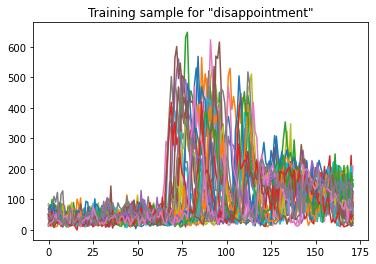

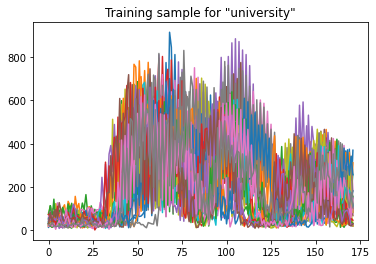

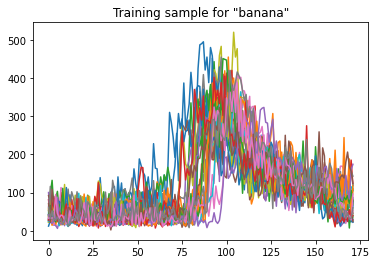

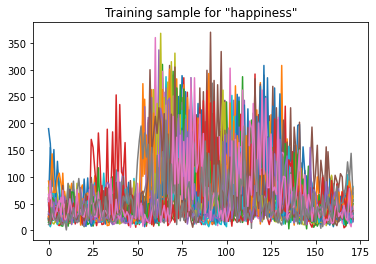

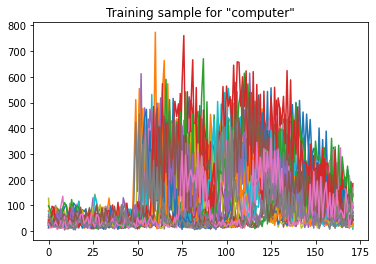

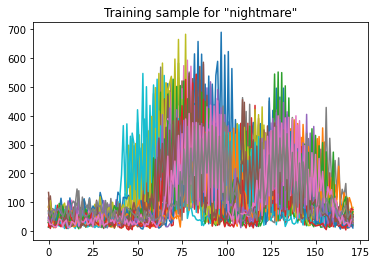

In [63]:
# Plot all training samples
word_number = 0
selected_words_arr = all_words_arr
for word_raw_train in train_dict.values():
    plt.plot(word_raw_train.T)
    plt.title('Training sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

### 3.2 Align Audio Recordings

As you can see above, the speech is only a small part of the 2 second window, and each sample starts at different times. PCA is not good at interpreting delay, so we need to somehow start in the same place each time and capture a smaller segment of the 2 second sample where the speech is present. To do this, we will use a thresholding algorithm.

First, we define a **`threshold`** relative to the maximum value of the data. We say that any signal that crosses the threshold is the start of a speech command. In order to not lose the first couple samples of the speech command, we say that the command starts **`pre_length`** samples before the threshold is crossed. We then take a window of the data that is **`length`** long, and try to capture the entire sound of the command in that window.

<b>The parameters `length`, `pre_length` and `threshold`</b> are defined with default values in the cells below. The default length value corresponds to a reasonable length for vectors we can use, because the Launchpad has limited storage and memory and cannot store too much.

Finding the optimal set of parameters is an arduous task that we would rather not accomplish manually, so we will be leaving that to a software algorithm to optimize for us. However, this requires us to implement the entire classifier in code first, as we need to give the algorithm something to optimize around (the classification rate). As such, we will use the default values given in the third code block below to preprocess our data, and use that to help guide us through the process of implementing our classifier. After this, you will have a visual reference for how things look after each step in the classifier, before we move on to optimizing these parameters algorithmically. You should see the results and how much of your command you captured in the plots generated below.

In [64]:
def get_snippets(data, length, pre_length, threshold):
    """Attempts to align audio samples in data.
    
    Args:
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
    
    Returns:
        Matrix of aligned recordings.
    """
    assert isinstance(data, np.ndarray) and len(data.shape) == 2, "'data' must be a 2D matrix"
    assert isinstance(length, int) and length > 0, "'length' of snippet must be an integer greater than 0"
    assert 0 <= threshold <= 1, "'threshold' must be between 0 and 1"
    snippets = []

    # Iterate over the rows in data
    for recording in data:
        # Find the threshold
        recording_threshold = threshold * np.max(recording)

        # Figure out when interesting snippet starts
        i = pre_length
        while recording[i] < recording_threshold:
            i += 1
            
        snippet_start = min(i - pre_length, len(recording) - length)
        snippet = recording[snippet_start:snippet_start + length]

        # Normalization
        snippet = snippet / np.sum(snippet)
        
        snippets.append(snippet)

    return np.vstack(snippets)

In [65]:
# Wrapper function for get_snippets
def process_data(dict_raw, length, pre_length, threshold, plot=True):
    """
    Process the raw data given parameters and return it.
    
    Args:
        dict_raw (np.ndarray): Raw data collected.
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
        plot (boolean): Plot the dataset if true.
            
    Returns:
        Processed data dictionary.
    """
    processed_dict = {}
    word_number = 0
    for key, word_raw in dict_raw.items():
        word_processed = get_snippets(word_raw, length, pre_length, threshold)
        processed_dict[key] = word_processed
        if plot:
            plt.plot(word_processed.T)
            plt.title('Samples for "{}"'.format(selected_words_arr[word_number]))
            word_number += 1
            plt.show()
            
    return processed_dict 

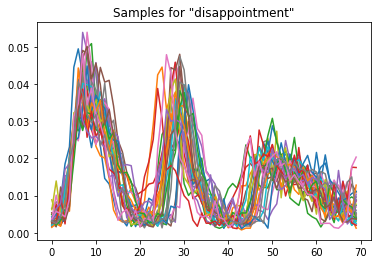

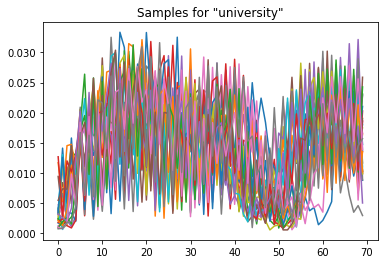

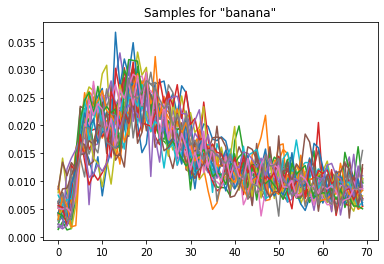

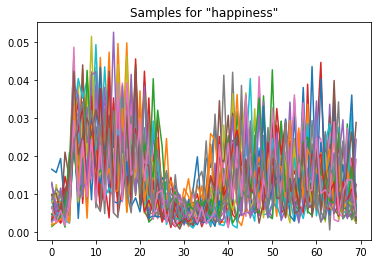

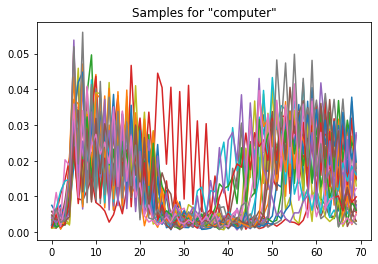

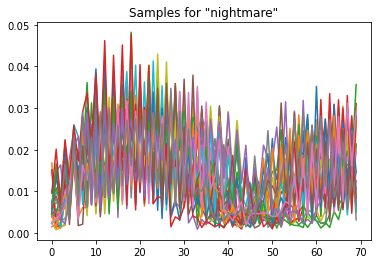

In [66]:
length = 70  # Default: 80
pre_length = 5 # Default: 5
threshold = 0.5 # Default: 0.5

processed_train_dict = process_data(train_dict, length, pre_length, threshold)

You should now see a more organized set of samples for each word. Can you tell which word is which just by the envelope? If an of your words looks nearly identical to another and you can't tell the words apart, then PCA will likely have a difficult time as well, so you may want to consider re-recording.

<a id='part4'></a>
## <span style="color:navy">Part 4: PCA via SVD</span>

### 4.0 SVD/PCA Resources
- http://www.ams.org/publicoutreach/feature-column/fcarc-svd
- https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
- https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8

### 4.1 Generate and Preprocess PCA Matrix

Now that we have our data in a nice format, we can build the PCA input matrix from that data by **stacking all the data vertically**.

**Sanity check:** What should be the dimensions of processed_A? Feel free to use np.shape() if you aren't sure.

**<span style='color:violet'>- Number of columns: length of recording or timestep</span>**

**<span style='color:violet'>- Number of rows: total number of samples/recordings across all words</span>**


In [67]:
processed_A = np.vstack(list(processed_train_dict.values()))
print(processed_A.shape)

(168, 70)


The first step of PCA is to zero-mean your data as `demeaned_A`. Centering the data can be helpful to obtain principal components that are representative of the shape of the variations in the data. Please note that you want to **get the mean of each feature** (***what are the features?***). The function [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) might be helpful here, along with specifying the axis parameter.

**Sanity check:** Does the shape of `mean_vec` make sense given what we averaged across?

In [68]:
# Zero-mean the matrix A
# YOUR CODE HERE
mean_vec = np.mean(processed_A, axis=0)
demeaned_A = processed_A - mean_vec
print(processed_A.shape)
print(mean_vec.shape)

(168, 70)
(70,)


### 4.2 Principal Component Analysis

Next, take the SVD of your demeaned data. Don't worry about the "Line 1 for parameter tuning" for now, we will come back to that later when we optimize length, prelength, and threshold.

In [69]:
# Take the SVD of matrix demeaned_A (np.linalg.svd)
# YOUR CODE HERE #
U, S, Vt = np.linalg.svd(demeaned_A)          # Line 1 for parameter tuning

Take a look at your sigma values. They should show you very clearly how many principal components you need.

<StemContainer object of 3 artists>

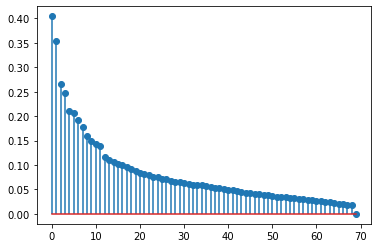

In [70]:
# Plot out the sigma values (Hint: Use plt.stem for a stem plot)
# YOUR CODE HERE #
plt.stem(S)

**<span style="color:red">How many principal components do you need? Given that you are sorting 6 words, what is the number you expect to need?</span>** 

There is no correct answer here. We can pick as many principal components onto which we project our data to get the "best" separation (most variance), but at some point, the cost-benefit isn't worth selecting an extra basis vector. For example, in our project, we are loading these basis vectors onto the [MSP430 Launchpad](http://www.ti.com/tool/MSP-EXP430F5529LP), and we can only store at most 3 principal components before we run into memory issues.

### 4.3 Choosing a Basis using Principal Components

Set the `new_basis` argument to be a basis of the first 3 principal components. (Hint: Of the three outputs from the SVD function call, which one will contain the principal components onto which we want to project our data points? Do we need to transpose it? **The lab note will help!**)

When you plot `new_basis` you should see a number of line plots equal to the number of principal components you've chosen (3).

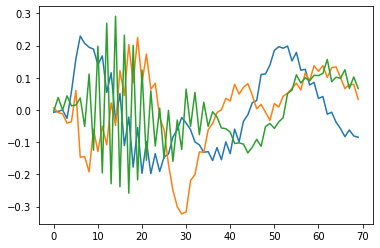

In [71]:
# Plot the principal component(s)
# YOUR CODE HERE
new_basis = np.array([Vt[0], Vt[1], Vt[2]]).T       # This should be the basis containing your principal components. Line 2 for parameter tuning
plt.plot(new_basis)

Now project the data in the matrix A onto the new basis and plot it. For three principal components, in addition to the 3D plot, we also provided 2D plots which correspond to the top and side views of the 3D plot. Do you see clustering? Do you think you can separate the data easily? Don't worry too much if it doesn't look perfect, as we haven't optimized our preprocessing parameters yet. As long as you see clustering, it's fine.

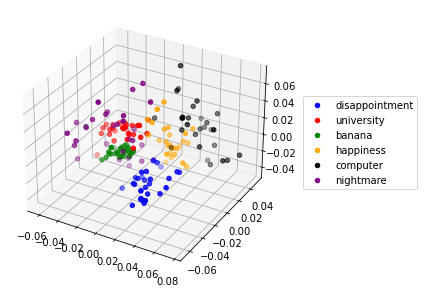

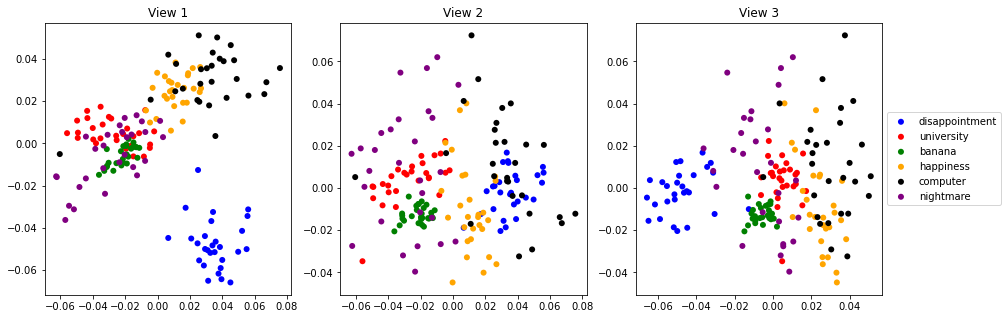

In [72]:
# Project the data onto the new basis
# YOUR CODE HERE. Hint: np.dot() may help, as well as printing the dimensions.
proj = np.dot(demeaned_A, new_basis)

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(all_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(all_words_arr)):
        axs[0].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_train:num_samples_train*(i+1),1], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,5))
    for i in range(len(all_words_arr)):
        plt.scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], edgecolor='none')

    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Your data might look noisy, and might not classify perfectly. That is completely okay, we are just looking for good enough. Like many AI applications, this is noisy data that we are classifying so some error in classification is okay. The important part is that you see strong clustering of your words. 

If you don't see clustering, try to think about why this might be the case. Things you might want to ask yourself:
- How does PCA create the clusters? 
- What characteristics of your waveform will PCA favor when clustering? 
- How can you choose your words such that it maximizes the distinction between your different classes?

Once you think you have decent clustering, you can move on to getting your code to automate classification and you will make up for some of the error there, too. **Choose 4 out of the 6 words that form the most distinct clusters. You will be using these four words for the rest of this lab.** Again, this will also be optimized later by our algorithm, so don't worry too much about choosing the perfect words.

In [73]:
# YOUR CODE HERE
selected_words_arr = ['disappointment', 'banana', 'happiness', 'university']

# Select data
selected_train_dict = {k: train_dict[k] for k in selected_words_arr}
selected_processed_train_dict = {k: processed_train_dict[k] for k in selected_words_arr}
selected_test_dict = {k: test_dict[k] for k in selected_words_arr}

num_samples_train = min(list(map(lambda x : np.shape(x)[0], selected_train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], selected_test_dict.values())))

# Reconstruct data based on 4 chosen words.
processed_A = np.vstack(list(selected_processed_train_dict.values()))
mean_vec = np.mean(processed_A, axis=0)
demeaned_A = processed_A - mean_vec
proj = demeaned_A.dot(new_basis)

<a id='part5'></a>
## <span style="color:navy">Part 5: Clustering Data Points</span>

#### Implement `find_centroids` which finds the center of each cluster.

In [74]:
def find_centroids(clustered_data, num_samples_train):
    """Find the center of each cluster by taking the mean of all points in a cluster.
    It may be helpful to recall how you constructed the data matrix (e.g. which rows correspond to which word)
    
    Parameters:
        clustered_data: the data already projected onto the new basis
        num_samples_train: the number of samples trained
        
    Returns: 
        The centroids of the clusters
    """
    centroids = []
    # YOUR CODE HERE
    for i in range(0,4):
        spliced_data = np.mean(clustered_data[i * (num_samples_train // 4):(i + 1) * (num_samples_train // 4)], axis=0)
        centroids.append(spliced_data)
    
    # Hint: the variable num_samples_train may help you splice into your clustered_data, as well as np.mean()
    # Feel free to ignore the skeleton code if you wish to write it your way.
    
    return centroids

Fill in the code below to find the centroids of each cluster.

In [75]:
# Determine the centroids of each cluster
# YOUR CODE HERE: hint: call find_centroids()
centroids = find_centroids(proj, 112)          # Line 3 for parameter tuning
print(centroids)

print(proj.shape)

[array([ 0.03583486, -0.04157654,  0.00330978]), array([-0.02087518,  0.00030562, -0.00757247]), array([ 0.01175234,  0.03026725, -0.00452983]), array([-0.02671201,  0.01100368,  0.00879253])]
(112, 3)


Run the cell below to plot your centroids along with your projected data.

Centroid 0 is at: [ 0.03583486 -0.04157654  0.00330978]
Centroid 1 is at: [-0.02087518  0.00030562 -0.00757247]
Centroid 2 is at: [ 0.01175234  0.03026725 -0.00452983]
Centroid 3 is at: [-0.02671201  0.01100368  0.00879253]


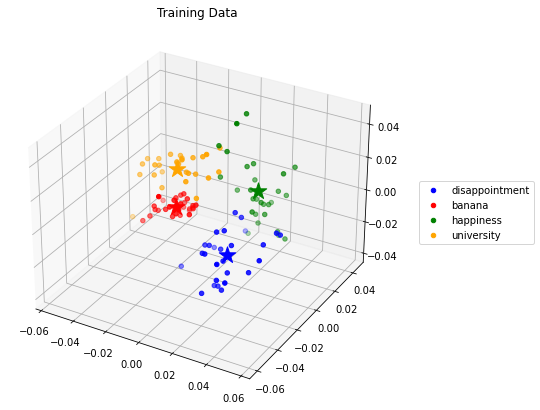

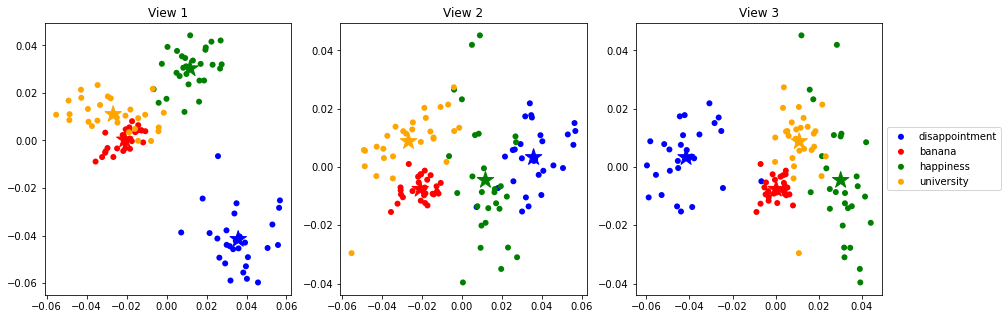

In [76]:
centroid_list = np.vstack(centroids)
colors = cm[:(len(centroids))]

for i, centroid in enumerate(centroid_list):
    print('Centroid {} is at: {}'.format(i, str(centroid)))

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1.07, 0.5))
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    plt.title("Training Data")
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_train:num_samples_train*(i+1),1], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    plt.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Training Data")
    plt.show()

<a id='part6'></a>
## <span style="color:navy">Part 6: Testing your Classifier</span>

Great! We now have the means (centroid) for each word. Now let's see how well our test data performs. Recall that we will classify each data point according to the centroid that it is closest in Euclidean distance to. 

Before we perform classification, we need to do the same preprocessing to the test data that we did to the training data (enveloping, demeaning, projecting onto the PCA basis). You have already written most of the code for this part. However, note the difference in variable names as we are now working with test data.

First let's look at what our raw test data looks like.

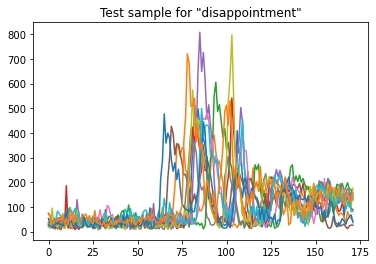

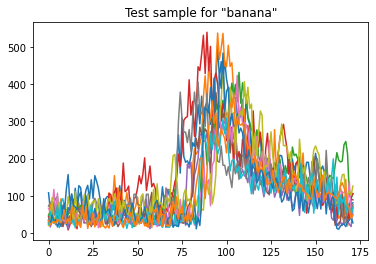

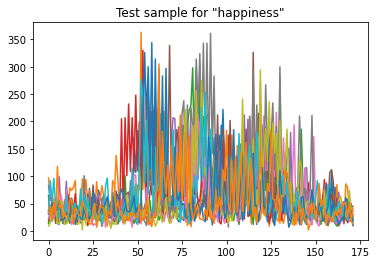

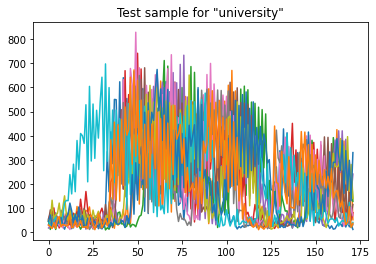

In [77]:
# Plot all test samples
word_number = 0
for word_raw_test in selected_test_dict.values():
    plt.plot(word_raw_test.T)
    plt.title('Test sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

Perform enveloping and trimming of our test data.

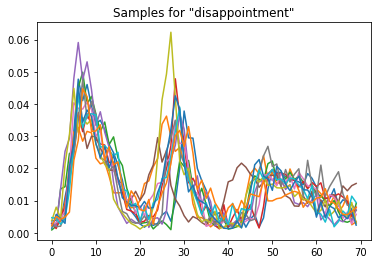

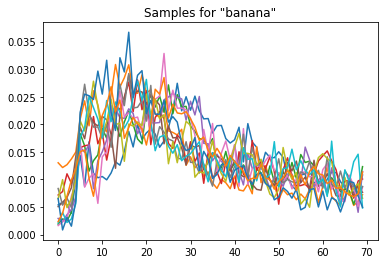

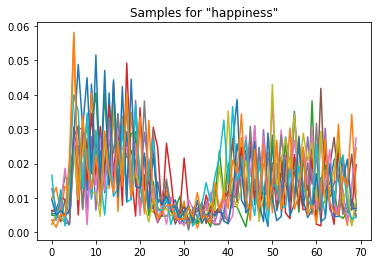

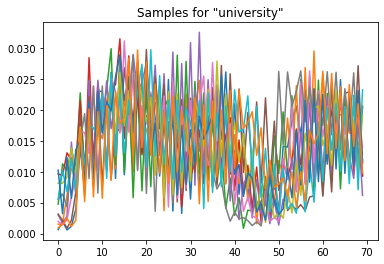

In [78]:
processed_test_dict = process_data(selected_test_dict, length, pre_length, threshold)

Construct the PCA matrix by stacking all the test data.

In [79]:
selected_processed_test_dict = {k: processed_test_dict[k] for k in selected_words_arr}

processed_A_test = np.vstack(list(selected_processed_test_dict.values()))

**Now we will do something slightly different.**

Previously, you projected data onto your PCA basis with $ (x - \bar{x})P $, where $\bar{x}$ is the mean vector, x is a single row of `processed_A`, and P is `new_basis`. 

We can rewrite this operation as 

$$ (x - \bar{x})P = xP - \bar{x}P = xP - \bar{x}_{\text{proj}} $$ 
$$ \bar{x}_{\text{proj}} = \bar{x}P $$

Why might we want to do this? We'll later perform these operations on our car. Our Launchpads have limited memory, so we want to store as little as possible. Instead of storing a length $n$ vector $\bar{x}$, we can precompute $ \bar{x}_{\text{proj}} $ (length 3) and store that instead!

Compute $ \bar{x}_{\text{proj}} $ using the **same mean vector** as the one computed with the training data.

In [80]:
# YOUR CODE HERE
projected_mean_vec = np.dot(mean_vec, new_basis)                 # Line 4 for parameter tuning

Project the test data onto the **same PCA basis** as the one computed with the training data.

In [81]:
# YOUR CODE HERE
projected_A_test = np.dot(processed_A_test, new_basis)                     # Line 5 for parameter tuning

Zero-mean the projected test data using the **`projected_mean_vec`**.

In [82]:
# YOUR CODE HERE
proj = projected_A_test - projected_mean_vec                                 # Line 6 for parameter tuning

Plot the projections to see how well your test data clusters in this new basis. This will give you an idea of how well your test data will classify.

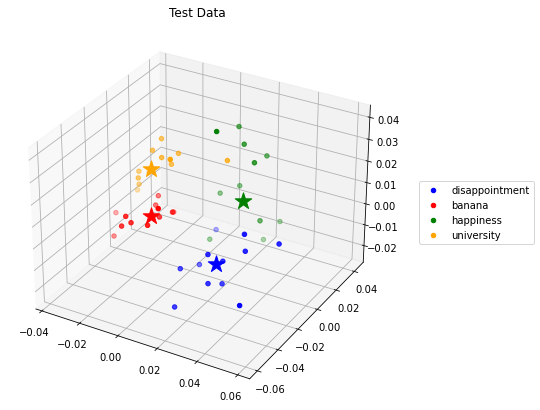

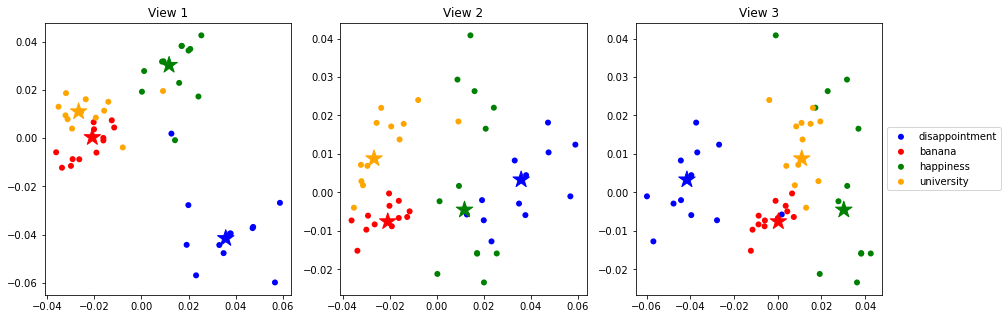

In [83]:
if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_test:num_samples_test*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    plt.title("Test Data")
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_test:num_samples_test*(i+1),1], proj[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    fig.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Test Data")
    plt.show()

Now that we have some idea of how our test data looks in our PCA basis, let's see how our data actually performs. Implement the classify function that takes in a data point (AFTER enveloping is applied) and returns which word number it belongs to depending on which centroid the data point is closest in Euclidean distance to.

In [84]:
def classify(data_point, new_basis, projected_mean_vec, centroids):
    """Classifies a new voice recording into a word.
    
    Args:
        data_point: new data point vector before demeaning and projection
        new_basis: the new processed basis to project on
        projected_mean_vec: the same projected_mean_vec as before
    Returns:
        Word number (should be in {1, 2, 3, 4} -> you might need to offset your indexing!)
    Hint:
        Remember to use 'projected_mean_vec'!
        Np.argmin(), and np.linalg.norm() may also help!
    """
    # TODO: classify the demeaned data point by comparing its distance to the centroids
    # YOUR CODE HERE
    projected_data_point = np.dot(data_point, new_basis)
    demeaned = projected_data_point - projected_mean_vec
    distances = []
    for i in range(0, 4):
        distances.append(np.linalg.norm(demeaned - centroids[i]))
    return np.argmin(distances) + 1

Try out the classification function below.

In [85]:
# Try out the classification function
for i in range(48):
    print(classify(processed_A_test[i,:], new_basis, projected_mean_vec, centroids)) # Modify the row index of processed_A_test to use other vectors

1
1
1
1
1
3
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
3
4
4
4
4
4
4
4
3
4
4
4
4


**Our goal is 80% accuracy for each word.** Apply the `classify` function to each sample and compute the accuracy for each word. Don't worry if you don't meet the goal right now; we are about to optimize our preprocessing parameters in the next part of the lab.

In [86]:
# Try to classify the whole A matrix
correct_counts = np.zeros(4)

for (row_num, data) in enumerate(processed_A_test):
    word_num = row_num // num_samples_test + 1
    if classify(data, new_basis, projected_mean_vec, centroids) == word_num:
        correct_counts[word_num - 1] += 1
        
for i in range(len(correct_counts)):
    print("Percent correct of word {} = {}%".format(i + 1, 100 * correct_counts[i] / num_samples_test))

Percent correct of word 1 = 91.66666666666667%
Percent correct of word 2 = 100.0%
Percent correct of word 3 = 91.66666666666667%
Percent correct of word 4 = 91.66666666666667%


<a id='part7'></a>
## <span style="color:navy">Part 7: Tuning for Best Performance</span>
In this part, we will optimize our preprocessing parameters to achieve the best classification rate. **You do not need to understand any of this code for the optimizer**. This code comes courtesy of Andris Huang, a student in EECS 16B Fall 2021.

Here we define a function the optimizer will use. Copy the lines marked with a comment "Line # for parameter tuning" from up above into the corresponding lines below.

In [87]:
def load_data(length, pre_length, threshold, selected_words_arr):
    processed_train_dict = process_data(train_dict, length, pre_length, threshold, plot=False)
    processed_A = np.vstack(list(processed_train_dict.values()))
    mean_vec = np.mean(processed_A, axis=0)
    demeaned_A = processed_A - mean_vec
    
    U, S, Vt = np.linalg.svd(demeaned_A) # Copy Line 1 Here
    new_basis = np.array([Vt[0], Vt[1], Vt[2]]).T # Copy Line 2 Here
    
    selected_train_dict = {k: train_dict[k] for k in selected_words_arr}
    selected_processed_train_dict = {k: processed_train_dict[k] for k in selected_words_arr}
    selected_test_dict = {k: test_dict[k] for k in selected_words_arr}
    processed_A = np.vstack(list(selected_processed_train_dict.values()))
    mean_vec = np.mean(processed_A, axis=0)
    demeaned_A = processed_A - mean_vec
    proj = demeaned_A.dot(new_basis)
    
    num_samples_train = min(list(map(lambda x : np.shape(x)[0], selected_train_dict.values())))
    num_samples_test = min(list(map(lambda x : np.shape(x)[0], selected_test_dict.values())))

    centroids = find_centroids(proj, 112) # Copy Line 3 Here
    
    processed_test_dict = process_data(selected_test_dict, length, pre_length, threshold, plot=False)
    selected_processed_test_dict = {k: processed_test_dict[k] for k in selected_words_arr}
    processed_A_test = np.vstack(list(selected_processed_test_dict.values()))
    
    projected_mean_vec = np.dot(mean_vec, new_basis) # Copy Line 4 Here
    projected_A_test = np.dot(processed_A_test, new_basis) # Copy Line 5 Here
    proj = projected_A_test - projected_mean_vec # Copy Line 6 Here
    
    return processed_A_test, new_basis, projected_mean_vec, centroids, num_samples_test

Here we define the objective the optimizer tries to optimize. The optimizer uses all_words_arr with ranges for length (default 70 to 90), pre_length (default 0 to 9), and threshold (default 0 to 0.99) and considers different combinations of words with different parameter values within these ranges. Note that this default range may not be what is best for your set of words; it may not capture the entire length of your words or it may capture too much silence around them instead. You may need to adjust this range with your specific words in mind, though you should not go above 100 in length.

In [88]:
def objective(trial):
    """
    Defines an objective that we try to optimize. In this lab, it's the accuracy for classification. 
    Simply run this block.
    
    Args:
        trial (object): a specific trial with given combinations of parameters
        
    Returns:
        -1 if the given combination of param is not compatible with the model;
        The number of past test cases if fewer than 4 cases are passed. Thus, returns value in [0, 3];
        The average percent correct of word if all 4 test cases are passed. The % sign is omitted.
    """
    length = trial.suggest_int('length', 70, 90) # Default: 80               # Suggest range for length
    pre_length = trial.suggest_int('pre_length', 0, 9) # Default: 5          # Suggest range for pre_length
    threshold = trial.suggest_float('threshold', 0., 0.99) # Default: 0.5    # Suggest range for threshold
    selected_words_arr = trial.suggest_categorical('selected_words_arr', 
        list(itertools.combinations(all_words_arr, 4)))                      # Suggest word combinations

    try:
        data = load_data(length, pre_length, threshold, selected_words_arr)
        processed_A_test, new_basis, projected_mean_vec, centroids, num_samples_test = data
    except:
        return -1 # the given combination of param is not compatible with the model
    
    correct_counts = np.zeros(4)
    for (row_num, data) in enumerate(processed_A_test):
        word_num = row_num // num_samples_test + 1
        if classify(data, new_basis, projected_mean_vec, centroids) == word_num:
            correct_counts[word_num - 1] += 1
                
    num_pass = 0
    total_auc = 0
    for i in range(len(correct_counts)):
        auc = 100 * correct_counts[i] / num_samples_test
        total_auc += auc
        if auc >= 80:
            num_pass += 1
    if num_pass < 4:
        return num_pass
    return total_auc / len(correct_counts)

Now, let's run the optimizer. You do not need to change any of the parameters.

In [89]:
study = utils.create_study()
study.optimize(objective, n_trials=50, timeout=60) # Can change the number of trials and timeout (in seconds)

[I 2022-04-28 16:46:38,808] A new study created in RDB with name: HPO/HPO_17
[I 2022-04-28 16:46:39,291] Trial 0 finished with value: 2.0 and parameters: {'length': 72, 'pre_length': 8, 'threshold': 0.8322694493604637, 'selected_words_arr': ('university', 'banana', 'happiness', 'computer')}. Best is trial 0 with value: 2.0.
[I 2022-04-28 16:46:39,786] Trial 1 finished with value: 3.0 and parameters: {'length': 76, 'pre_length': 3, 'threshold': 0.3803142381940667, 'selected_words_arr': ('disappointment', 'university', 'banana', 'happiness')}. Best is trial 1 with value: 3.0.
[I 2022-04-28 16:46:40,226] Trial 2 finished with value: 0.0 and parameters: {'length': 71, 'pre_length': 6, 'threshold': 0.2022207580201987, 'selected_words_arr': ('university', 'happiness', 'computer', 'nightmare')}. Best is trial 1 with value: 3.0.
[I 2022-04-28 16:46:40,625] Trial 3 finished with value: 1.0 and parameters: {'length': 89, 'pre_length': 4, 'threshold': 0.030418207660067226, 'selected_words_arr': (

[I 2022-04-28 16:46:52,551] Trial 29 finished with value: 3.0 and parameters: {'length': 73, 'pre_length': 5, 'threshold': 0.8714372876135728, 'selected_words_arr': ('disappointment', 'university', 'banana', 'computer')}. Best is trial 10 with value: 95.83333333333334.
[I 2022-04-28 16:46:53,020] Trial 30 finished with value: 87.5 and parameters: {'length': 81, 'pre_length': 6, 'threshold': 0.679667589261285, 'selected_words_arr': ('disappointment', 'university', 'banana', 'computer')}. Best is trial 10 with value: 95.83333333333334.
[I 2022-04-28 16:46:53,435] Trial 31 finished with value: 3.0 and parameters: {'length': 76, 'pre_length': 3, 'threshold': 0.4673253610264945, 'selected_words_arr': ('disappointment', 'happiness', 'computer', 'nightmare')}. Best is trial 10 with value: 95.83333333333334.
[I 2022-04-28 16:46:53,925] Trial 32 finished with value: 93.75000000000001 and parameters: {'length': 78, 'pre_length': 3, 'threshold': 0.5321321118806754, 'selected_words_arr': ('disappo

In [90]:
# Print the best stats
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  95.83333333333334
  Params: 
    length: 76
    pre_length: 3
    selected_words_arr: ['disappointment', 'university', 'banana', 'happiness']
    threshold: 0.5616058649032891


Now that we have our optimized words list and preprocessing parameters, let's try our classification again and see if it improved.

In [91]:
length_opt = trial.params['length']
pre_length_opt = trial.params['pre_length']
threshold_opt = trial.params['threshold']
selected_words_arr_opt = trial.params['selected_words_arr']
processed_A_test_opt, new_basis_opt, projected_mean_vec_opt, centroids_opt = load_data(length, pre_length, threshold, selected_words_arr)[:4]

correct_counts = np.zeros(4)

for (row_num, data) in enumerate(processed_A_test_opt):
    word_num = row_num // num_samples_test + 1
    if classify(data, new_basis_opt, projected_mean_vec_opt, centroids_opt) == word_num:
        correct_counts[word_num - 1] += 1
        
for i in range(len(correct_counts)):
    print("Percent correct of word {} = {}%".format(i + 1, 100 * correct_counts[i] / num_samples_test))

Percent correct of word 1 = 91.66666666666667%
Percent correct of word 2 = 100.0%
Percent correct of word 3 = 91.66666666666667%
Percent correct of word 4 = 91.66666666666667%


You should now be able to meet the 80% classification accuracy we require! If not, you may need to re-record some of your words or adjust some parameter ranges for the optimizer. Otherwise, since the optimizer is not perfect, if your original parameters worked better, feel free to use those. Make sure to note down the values of `length`, `pre_length` and `threshold` that you choose - <b>you will need to add them to the Launchpad sketch later!</b>

<a id='part8'></a>
## <span style="color:navy">Part 8: Launchpad Implementation of PCA Classify</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB


With our completed classifier, we are now ready to classify live commands using our Launchpad. This section will walk you through implementing your classification algorithm on the Launchpad. You will need to transfer the preprocessing parameters, PCA vectors, projected mean vector, and centroids all into the Launchpad. **You will be copying and pasting the code from the Appendix of the SVD/PCA notebook into `classify.ino.`**

Your first task will be to implement your <b>data processing</b> and <b>classification</b> (just the projection, not the PCA) in the Launchpad sketch <b>`classify.ino`</b>. Since Energia does not have as many built-in functions as Python, you will have to write out the functions yourself. For example, a dot product should be written as:

```C
float dot_product_result = 0;
for (i = 0; i < LENGTH; i++) {
    dot_product_result += vector1[i] * vector2[i];
}
```
where `dot_product_result` is the result of the dot product, and `vector1` and `vector2` are the two vectors you're taking the dot product of.

NOTE: The coding language is a derivative of C/C++, so you need to follow C syntax! i.e. declaring variables before using them, using `{` and `}` to denote the start and end of a for loop, adding a `;` to the ends of lines, etc. You can reference the existing code for examples of how to use the proper syntax.

For debugging purposes, you can add print statements to the code. Printing to Energia's Serial Monitor looks like the line below.

`Serial.println("I'm being printed!");`

There are 3 code blocks (`PCA1/2/3`) that you need to modify. <b>You should not have to change anything else outside these marked code blocks and the pin definition if you're using a different pin than the default `P6.0` pin.</b> 

**`CODE BLOCK PCA1`**
- Copy the `SNIPPET_SIZE`, `PRELENGTH` and `THRESHOLD` from the appendix section of the PCA ipynb.
- Read the following to set `EUCLIDEAN_THRESHOLD` and `LOUDNESS_THRESHOLD`.

**`EUCLIDEAN_THRESHOLD` filters the classification depending on a sample's distance to the closest centroid.** If the L2 norm (distance) is larger than the threshold, your classification algorithm should simply ignore it and wait for the next sample. Look at the plot of your data clusters and the centroids from earlier in this notebook and approximate a radius around the centroids that capture most of the data. **Try to be conservative - it's better to not classify than to misclassify.**

**`LOUDNESS_THRESHOLD` filters the classification depending on the amplitude of the recorded data.** If the recorded data is too soft, we do not want to classify it as it is probably noise. Look at the plots of the audio recordings to determine the loudness of your recordings, then determine an appropriate threshold that isn't low enough to be considered noise while also being below the maximum loudness. If the Launchpad classifies noise, increase this constant. If it misses a lot of speech (i.e. thinks your word is noise), decrease this constant. This variable is used internally in the enveloping function.

**`CODE BLOCK PCA2`**
- Copy the PCA vectors, projected mean vector, and centroids from the appendix section of the SVD/PCA ipynb.
- If you are using 3 principal components, add a new `pca_vec3` array. 
- Note: Using more principal components increases the dimensionality of the centroids and projections, but also consumes more of the limited memory on the Launchpad.

**`CODE BLOCK PCA3`**
- This is the actual classification algorithm.
- Before this block, the call to `envelope` leaves the data vector of your recording in the array called `result`.
- Project this data onto your new PCA basis.
    - **Since the principal component vectors are orthonormal, they have unit norm and when you perform the projection of the recorded data vector onto the principal components, you only need to do the dot products between those vectors using the for loop.**
    - Use just one loop to project your recorded data vector onto both (or all 3, if you're using 3) of your PCA vectors.
    - Use the variables `proj1` and `proj2` to store the projection results.
    - If you're using 3 vectors, create a variable `proj3` in the same way `proj1` and `proj2` are defined.
- Demean the projection.
    - Remember that we **demean after projecting** to save memory on the Launchpad. Instead of finding $x - \bar{x}$ and then projecting onto the PCA basis, we first project and then demean, using $ y = x_{\text{proj}} - \bar{x}_{\text{proj}} $, where $x_{\text{proj}}$ is the projection of your data vector onto the PCA basis, and $\bar{x}_{\text{proj}}$ is the projection of your mean vector onto the PCA basis.
- Classify the projections using the centroids.
    - Find the distance between the projected data point and each centroid using the function `l2_norm` (for 2 principal components) or `l2_norm3` (for 3 principal components). Look up the function definition in the sketch.
    - Out of the 4 centroids, find the one with the smallest L2 norm.
    - Verify this distance is less than `EUCLIDEAN_THRESHOLD`. If it's not, print out an error statement saying this threshold was not satisfied so you have an easier time debugging.
- Print the classification to the Serial Monitor. The baud rate for this program is 38400, so make sure you change the baud rate of your Serial Monitor accordingly!

Before testing the code, probe the mic board's output with your oscilloscope and make sure that it is still centered around 1.65V. Now upload the sketch, (re)open the Serial Monitor, and press the reset button. Say your word and the Launchpad should recognize it! Try to get a reasonable accuracy (like at least 80-90%); it's okay if it misclassifies occasionally, but it should be accurate in general!

**<span style="color:red">If the Launchpad does not classify as well as you think it should, remember to play with the `EUCLIDEAN_THRESHOLD` and `LOUDNESS_THRESHOLD` variables.</span>** To debug the sketch, you can also print out any of the variables you have used, like the distance to the closest centroid.

Voila! Your SIXT33N car can recognize your words!

**<span style="color:red">Summary TODO</span>**
- **<span style="color:red">Fill in `CODE BLOCK PCA1`: Fill out `SNIPPET_SIZE`, `PRELENGTH`, `THRESHOLD`, `EUCLIDEAN_THRESHOLD`, and `LOUDNESS_THRESHOLD`</span>** 
- **<span style="color:red">Fill in `CODE BLOCK PCA2`: Copy the principal components, projected mean vector, and centroids from the SVD/PCA Jupyter notebook</span>**
- **<span style="color:red">Fill in `CODE BLOCK PCA3`: Do the actual classification.</span>**

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF</span>

- **Have all questions, code, and plots completed in this notebook.** Your GSI will check all your PCA code and plots.
- **Show your GSI that you've achieved 80% accuracy on your test data for all 4 words.** 
- Your GSI will also check that you have **submitted your `.csv` files for the 4 words to the Gradescope assignment: "[Hands-on] SVD/PCA Files." Only one person in lab group needs to submit and needs to add all group members to same submission on Gradescope!**
- **Show your GSI that you are able to classify live while running `classify.ino`.**
- **Be prepared to answer conceptual questions about the lab.** Make sure you have read the lab note before requesting a checkoff! Many checkoff questions are pulled straight from the lab note.

### Checkoff Request Link: https://links.eecs16b.org/lab-checkoff-sp22

## SAVE ALL YOUR DATA!!

- Make sure to save the formatted vectors below and `classify.ino` for Integration/Final Demo!
- **Data stored on the lab computers often gets deleted automatically.** Please store it on your personal flash drive or cloud storage like Google Drive, and not on the lab computers! If you used DataHub, it should save through your CalNet ID.
- **You will need everything for the final lab report.**

<a id='appendix'></a>
## <span style="color:navy">Appendix: Formatting Vectors for Energia</span>

First, uncomment the following block if you will use the optimizer parameters and leave it commented if you will use the original parameters. Then run the following code blocks and copy/paste the following printed code into **`classify.ino`**

In [92]:
#uncomment to use the optimizer parameters

length = length_opt
pre_length = pre_length_opt
threshold = threshold_opt
new_basis = new_basis_opt
projected_mean_vec = projected_mean_vec_opt
centroids = centroids_opt


In [93]:
print("Paste the code below into 'CODE BLOCK PCA1':")
print("")
print(utils.format_constant_energia("SNIPPET_SIZE", length))
print(utils.format_constant_energia("PRELENGTH", pre_length))
print(utils.format_constant_energia("THRESHOLD", threshold))

Paste the code below into 'CODE BLOCK PCA1':

#define SNIPPET_SIZE                  76
#define PRELENGTH                     3
#define THRESHOLD                     0.5616058649032891


In [94]:
print("Paste the code below into 'CODE BLOCK PCA2':")
print("")
print(utils.format_array_energia("pca_vec1", new_basis[:, 0]))
print(utils.format_array_energia("pca_vec2", new_basis[:, 1]))
if new_basis.shape[1] == 3:
    print(utils.format_array_energia("pca_vec3", new_basis[:, 2]))
print(utils.format_array_energia("projected_mean_vec", projected_mean_vec))
print(utils.format_array_energia("centroid1", centroids[0]))
print(utils.format_array_energia("centroid2", centroids[1]))
print(utils.format_array_energia("centroid3", centroids[2]))
print(utils.format_array_energia("centroid4", centroids[3]))

Paste the code below into 'CODE BLOCK PCA2':

float pca_vec1[70] = {-0.006985729180859833, -0.004217534005264367, 7.072907193139688e-05, -0.026217336185542617, 0.05670810534273216, 0.15810472266853692, 0.2297131642284216, 0.20684698958269213, 0.19480299019400826, 0.18891597564845058, 0.1409233877217927, 0.16786165779298978, 0.05433385028891864, 0.1157218306021767, -0.03233902161540566, 0.05114910152297567, -0.11054489593398034, -0.022093470457464452, -0.17719346803327082, -0.05450667798540091, -0.196653224064299, -0.0984087324556748, -0.19753205128038998, -0.1356750302256956, -0.19104862979842935, -0.14595915836882528, -0.13674544318418325, -0.08425522058186787, -0.0610759661172743, -0.0233658138499568, -0.04055043523088523, -0.06131786497461418, -0.099044057549232, -0.10835906349284585, -0.13133008647334873, -0.12936688913339853, -0.1571530027419381, -0.116817826064326, -0.15452376458234524, -0.09907956163902412, -0.1354618986455833, -0.05961617967402901, -0.09969910928746364, -0.0348